In [16]:
import pandas as pd
import numpy as np
import os
import mne
import hcp
import os

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [17]:
##taken from steves notebook

def spectral_features(raw: mne.io.Raw, max_freq: int = 100, n_fft: int = 48) -> np.array: 
    """Compute flattened spectral features given a cropped raw recording.
    Data is low-pass filtered to max_freq (default 100Hz) and downsampled to 2*max_freq before features are
    computed. 
    Computes a n_fft (default 48) point FFT. Takes the log to compute the final features which
    are then concatenated into a one dimensional feature vector.
    Returns a N x 24 np.array where N is the number of channels"""

    raw.filter(None, max_freq, h_trans_bandwidth=0.5, filter_length='10s', phase='zero-double', fir_design='firwin2')
    raw.resample(2*max_freq, npad="auto")

    psds, _freqs = mne.time_frequency.psd_welch(raw, fmin=1, n_fft=n_fft)

    #return np.ravel(np.log(psds))
    return np.log(psds)

def spectral_epochs(label: str, raw: mne.io.Raw, epoch_size: int, max_freq: int = 100, n_fft: int = 48) -> np.array: 
    """Read raw data and split into epochs of a given size (s), compute features
    over each one
    label: subject identifier
    epoch_size: duration of epochs in seconds
    data_folder: location of source data
    max_freq: max frequency for FFT (default 100)
    n_fft: FFT size (default 48)
    Returns: labels, features
    labels: a list of labels with the format <subject>-<run_index>-<N>
    features: a list of np.arrays one per epoch containing the features
    """

    features = []
    labels = []

    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_size)
    epochs = mne.Epochs(raw, events, tmin=0., tmax=epoch_size, baseline=None,
                        detrend=1, decim=8, preload=True)

    
    for N in range(len(epochs)):
        features.append(spectral_features(epochs[N], max_freq=max_freq, n_fft=n_fft))
        labels.append("{}-{}".format(label, N))
        print('.', end='', flush=True)
    print('|', end='', flush=True)        
    return labels, features


In [18]:
def read_hcp(subject: str, data_folder: str, run_index: int) -> mne.io.Raw:
    """
    Read a data file from the HCP dataset, return a Raw instance
    """

    raw = hcp.read_raw(subject=subject, data_type='rest', hcp_path=data_folder, run_index=run_index)

    return raw


def read_mous(subject: str, data_folder: str) -> mne.io.Raw:
    """
    Read a data file from the MOUS dataset, return a Raw instance
    """
    return read_mne(subject,data_folder,'{}/sub-{}_task-rest_meg.ds'.format(subject, subject))

    #except:
        #return None
        
def read_mne(subject: str, data_folder: str,sub_path : str) -> mne.io.Raw:
    """
    Read a mne data file
    """
    raw_path = os.path.join(data_folder, sub_path)
    raw = mne.io.read_raw_ctf(raw_path, preload=True)
    picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True, exclude='bads') 
    raw.pick(picks)
    return raw


In [19]:
MOUS_FOLDER = os.getcwd() + "/MOUS"

def getMousParticipants(folder : str):
    return [e[1] for e in os.walk(folder) ][0]

In [22]:
sample = read_mous(getMousParticipants(MOUS_FOLDER)[0],MOUS_FOLDER)

ds directory : /Users/billymihalarias/Documents/AHH Hackathon/MOUS/A2002/sub-A2002_task-rest_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.14   70.38    0.00 mm <->   -0.14   70.38    0.00 mm (orig :  -59.62   43.32 -250.29 mm) diff =    0.000 mm
       0.14  -70.38    0.00 mm <->    0.14  -70.38    0.00 mm (orig :   33.91  -61.72 -256.11 mm) diff =    0.000 mm
     105.09    0.00    0.00 mm <->  105.09    0.00    0.00 mm (orig :   65.30   59.22 -237.30 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/billymihalarias/Documents/AHH Hackathon/MOUS/A2002/sub-A2002_task-rest_meg.ds/sub-A2002_task-rest_meg.meg4: 
    Syste

In [23]:
print(sample.info['chs'][0]['loc'])

[ 6.73165656e-02 -6.73165656e-02  1.90000000e-01  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -7.07106781e-01  7.07106781e-01
  0.00000000e+00 -7.07106781e-01 -7.07106781e-01  6.15310286e-10]


In [24]:
print(len(sample.info['ch_names']))
print(len(sample.info['chs']))

301
301


In [27]:
positions = np.array([e['loc'][:3] for e in sample.info['chs']])

In [28]:
arrRange = np.array([np.around(e,decimals=3) for e in np.amax(positions,axis=0)]) - np.array([np.around(e,decimals=3) for e in np.amin(positions,axis=0)])
print(arrRange)
print(arrRange[:3])

[0.228 0.254 0.264]
[0.228 0.254 0.264]


In [29]:
def cart2polar(x):
    #theta then pi r is ommited. im taking x[0],1,2 to be x y z
    #taken from https://en.wikipedia.org/wiki/Spherical_coordinate_system
    radius = np.linalg.norm(x)
    return np.array([
        np.arccos(x[2]/radius), #arccos(z/r)
        np.arctan(x[1]/x[0]) #arctan(y/x)
    ]) 

In [30]:
polarPositions = np.array([cart2polar(e) for e in positions])

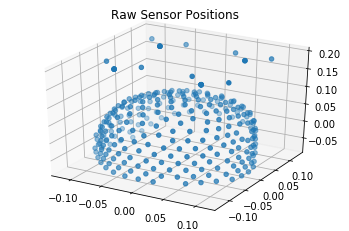

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(positions[:,0], positions[:,1], positions[:,2], cmap='Blues')
plt.title("Raw Sensor Positions")
None

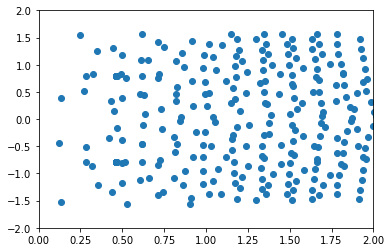

In [32]:
plt.scatter(x=polarPositions[:,0],y=polarPositions[:,1])
plt.xlim(0, 2)
plt.ylim(-2, 2)
plt.show()

In [33]:
print("max: {} min: {}".format(np.amax(polarPositions,axis=0),np.amin(polarPositions,axis=0)))

max: [2.15944746 1.56961847] min: [ 0.12259158 -1.5696815 ]


In [34]:
X_POLAR_RANGE = (0,2)
Y_POLAR_RANGE = (-1.6,1.6)
#cross verification with other models should be done to ensure these ranges include all sensors

In [35]:
def normScale(x,scale):
    return np.array([
        round(((x[0] - X_POLAR_RANGE[0]) / (X_POLAR_RANGE[1] - X_POLAR_RANGE[0]))*scale),
        round(((x[1] - Y_POLAR_RANGE[0]) / (Y_POLAR_RANGE[1] - Y_POLAR_RANGE[0]))*scale),
    ])

In [36]:
def partitionSpace(arr : np.ndarray,partitions : int =5):        
    return np.array([normScale(e,partitions) for e in arr])

In [37]:
PARTITIONS = 5
partitioned = partitionSpace(polarPositions,partitions=PARTITIONS)

In [38]:
cmap = {}

def addMap(e):
    cmap[tuple(e)] = np.random.rand(3)
    return cmap[tuple(e)]

groupCols = np.array([cmap[tuple(e)] if tuple(e) in cmap else addMap(e)  for e in partitioned])

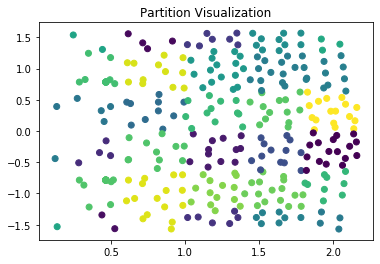

In [39]:
plt.scatter(x=polarPositions[:,0],y=polarPositions[:,1],c=groupCols[:,0])
plt.title("Partition Visualization")
None

## Resulting reduction

data points before processing 5952

data points after processing 864
